# Multi-Label Text Classification

Please check this [article](https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c?sk=8a30075009552cfd4a7534663edaed7e) for a detailed explanation.

In [1]:
import os
import re
import time
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
begin = time.time()

**Reading Data Files**

In [3]:
with ZipFile(os.path.join("data", "topics", 'train.csv.zip'), 'r') as myzip:
    with myzip.open('train.csv') as myfile:
        train_df = pd.read_csv(myfile)
        
with ZipFile(os.path.join("data", "topics", 'test.csv.zip'), 'r') as myzip:
    with myzip.open('test.csv') as myfile:
        test_df = pd.read_csv(myfile)

In [4]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


Lets now check the data types of columns.   
(Sometimes columns which contain float or integer values are assigned the data type object. In that case we need to change the data type.)

Now let's check each how many abstracts belongs to each category.

In [10]:
categories = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
category_count=[]
for i in categories:
    category_count.append(train_df[i].sum())

In [11]:
category_count

[8594, 6013, 5618, 5206, 587, 249]

<BarContainer object of 6 artists>

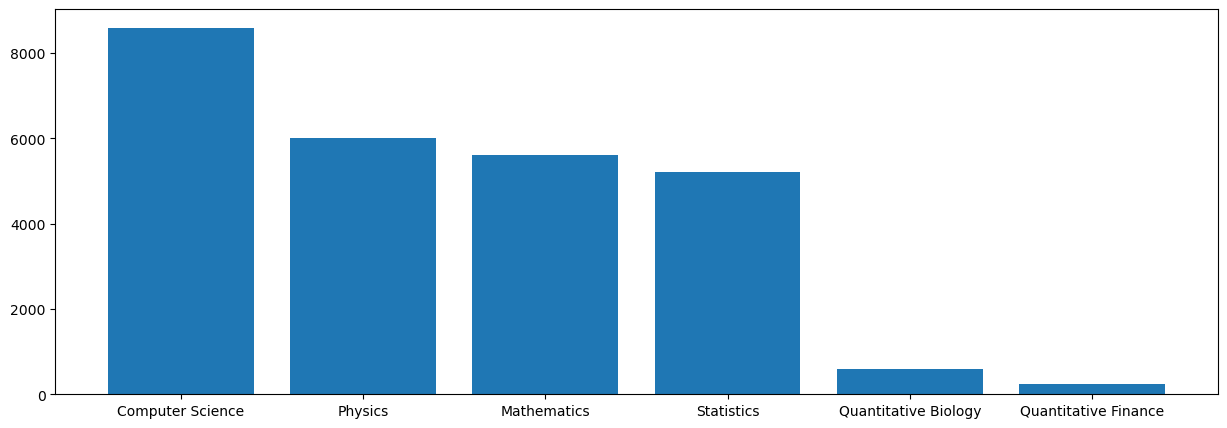

In [12]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count)

From the above plot its clear that "Quantitative biology" and "Quantitative Finance" have too few values compared to the other categories. This means that the data set is imbalanced.  
To make it balanced we can apply **resampling techniques**. The data set is small so we can try oversampling for these two classes.  

We will implement oversampling later. First we will try to build a basic classification model.

In [13]:
total_word_count_in_each_category=[]
for i in categories:
    abstracts = train_df.where(train_df[i] == 1)[['ABSTRACT']]
    count = pd.Series(abstracts.values.flatten()).str.len().sum()
    total_word_count_in_each_category.append(count)

<BarContainer object of 6 artists>

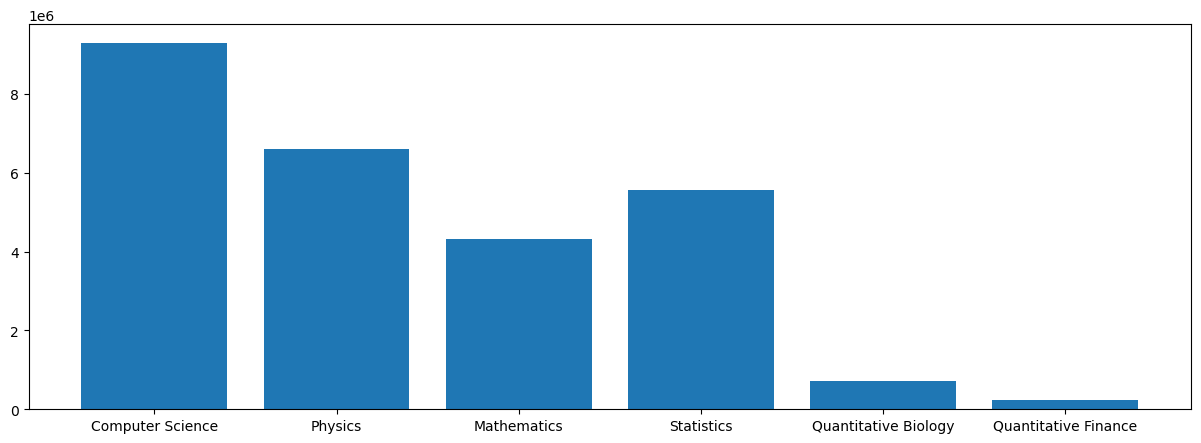

In [14]:
plt.figure(figsize=(15,5))
plt.bar(categories,total_word_count_in_each_category)

The word count is almost in the same proportion as the number of texts in each category. The only difference is statistics which has more words than mathematics even if the number of articles is more for mathematics.

In [15]:
avg_abstract_len_for_each_category=[]
for i in range(6):
    avg_abstract_len_for_each_category.append(total_word_count_in_each_category[i]/category_count[i])

<BarContainer object of 6 artists>

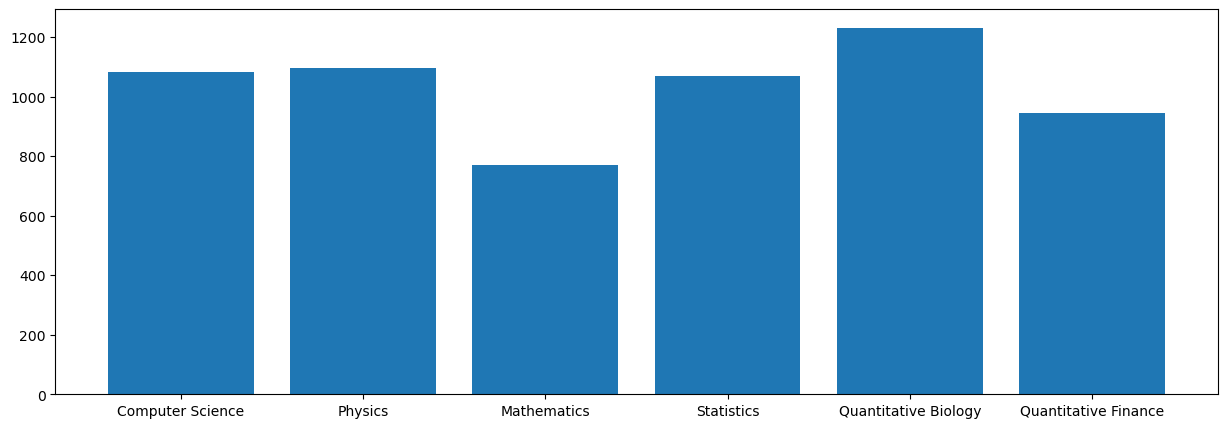

In [16]:
plt.figure(figsize=(15,5))
plt.bar(categories,avg_abstract_len_for_each_category)

From the above plot its clear that articles of quantitaive biology are the longest, and mathematics articles are the shortest.

Let's concatenate 'Title' and 'Abstract' and make it one big text.

In [17]:
train_df["text"] = train_df["TITLE"] + " " + train_df["ABSTRACT"]

We drop the 'Title' and 'Abstract' columns as they are not needed anymore. 

In [18]:
train_df.drop(["TITLE","ABSTRACT"],axis=1,inplace=True)

In [19]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


Let's make a function for train/test split as we will need this further.

In [20]:
def split(X,y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return (X_train, X_test, y_train, y_test)

# **Cleaning the text**

In [21]:
def clean_text(input_text):
    x = re.sub('[^\w]|_', ' ', input_text)  # only keep numbers and letters and spaces
    x = x.lower()
    x = re.sub(r'[^\x00-\x7f]',r'', x)  # remove non ascii texts
    x = [y for y in x.split(' ') if y] # remove empty words
    x = ['[number]' if y.isdigit() else y for y in x]
    cleaned_text =  ' '.join(x)
    return cleaned_text

In [22]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [23]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstructing subject specific effect maps pr...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation in...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonics and poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,a finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study of discrete wavelet transfor...


In [24]:
train_df.cleaned_text[0]

'reconstructing subject specific effect maps predictive models allow subject specific inference when analyzing disease related alterations in neuroimaging data given a subject s data inference can be made at two levels global i e identifiying condition presence for the subject and local i e detecting condition effect on each individual measurement extracted from the subject s data while global inference is widely used local inference which can be used to form subject specific effect maps is rarely used because existing models often yield noisy detections composed of dispersed isolated islands in this article we propose a reconstruction method named rsm to improve subject specific detections of predictive modeling approaches and in particular binary classifiers rsm specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers the proposed method is a wrapper type algorithm that can be used with different binary classifiers

In [25]:
X_train, X_test, y_train, y_test = split(train_df.loc[:,"cleaned_text"], train_df.loc[:,categories], 0.2)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16777,), (4195,), (16777, 6), (4195, 6))

Now that our text is cleaned we will apply Tfidf on the text data to convert it into a matrix of numericals.

# **Changing text into numericals using Tfidf technique**

In [27]:
tfidf = TfidfVectorizer(min_df=3, 
                        max_features=10000, 
                        strip_accents="unicode", 
                        analyzer="word",
                        token_pattern=r"\w{1,}",
                        ngram_range=(1,2),
                        use_idf=1,
                        smooth_idf=1,
                        sublinear_tf=1,
                        stop_words="english")

In [28]:
tfidf.fit(list(X_train)+list(X_test))

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
X_train_tfidf.shape

(16777, 10000)

The target column is made up of 6 columns , so lets change it to one columns with all 6 different categories.

In [30]:
y_train_new = y_train.idxmax(axis=1)
y_test_new = y_test.idxmax(axis=1)

In [31]:
y_train_new.nunique(), y_test_new.nunique()

(6, 6)

**Lest apply a simple LogisticRegression model to classify.**

Apply a grid search to optimize the hyperparameters.

In [32]:
params={
    'C':[0.8,1, 1.3],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty':['l1', 'l2', 'elasticnet', 'none']
}
gs_lr = GridSearchCV(LogisticRegression(),
                     param_grid=params,
                     scoring='accuracy',
                     cv=3, n_jobs=-1)

gs_model = gs_lr.fit(X_train_tfidf, y_train_new)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
81 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

In [33]:
gs_model.best_params_

{'C': 1.3, 'penalty': 'l2', 'solver': 'newton-cg'}

In [34]:
gs_model.best_params_['solver']

'newton-cg'

In [35]:
clf = LogisticRegression(C=gs_model.best_params_['C'],
                         solver=gs_model.best_params_['solver'],
                         penalty=gs_model.best_params_['penalty'],
                         n_jobs=-1)

clf.fit(X_train_tfidf, y_train_new)
clf.score(X_test_tfidf, y_test_new)

0.8092967818831943

In [36]:
train_preds = clf.predict(X_train_tfidf)
test_preds = clf.predict(X_test_tfidf)
train_preds

array(['Computer Science', 'Mathematics', 'Computer Science', ...,
       'Physics', 'Computer Science', 'Computer Science'], dtype=object)

**Evaluating the Model**

Our data set is imbalanced and all the classes are equally important, so for this case a macro average F1 score would be the best. The confusion matrix would then give an overall good picture of every class's prediction.

In [37]:
print('train f1 score', f1_score(y_train_new, clf.predict(X_train_tfidf), average='macro'))
print('test f1 score', f1_score(y_test_new, clf.predict(X_test_tfidf), average='macro'))
print("train accuracy",accuracy_score(y_train_new,clf.predict(X_train_tfidf)))
print("test accuracy",accuracy_score(y_test_new,clf.predict(X_test_tfidf)))

train f1 score 0.7678765890243232
test f1 score 0.5902567873717196
train accuracy 0.8933063122131489
test accuracy 0.8092967818831943


Text(122.31597222222221, 0.5, 'Actual')

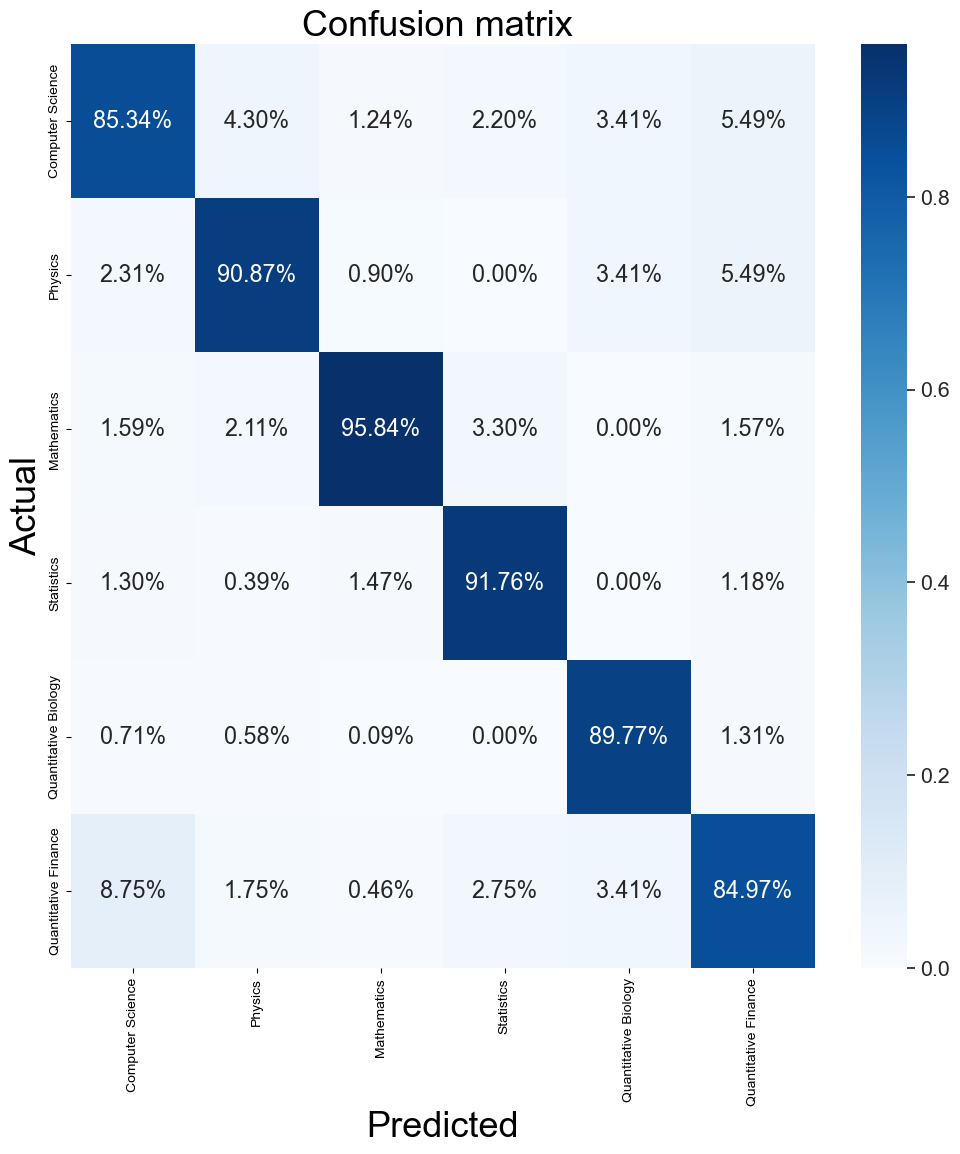

In [38]:
c_matrix = confusion_matrix(y_train_new,clf.predict(X_train_tfidf))

c_matrix = pd.DataFrame(c_matrix,columns=['Computer Science', 
                                          'Physics',
                                          'Mathematics', 
                                          'Statistics', 
                                          'Quantitative Biology', 
                                          'Quantitative Finance'],
                        index=['Computer Science',
                               'Physics',
                               'Mathematics',
                               'Statistics',
                               'Quantitative Biology',
                               'Quantitative Finance'])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix), fmt="0.2%", annot=True, cmap="Blues", ax=ax)
ax.set_title("Confusion matrix ", fontsize=26)
ax.set_xlabel("Predicted", fontsize=26)
ax.set_ylabel("Actual", fontsize=26)

Text(112.24999999999997, 0.5, 'Actual')

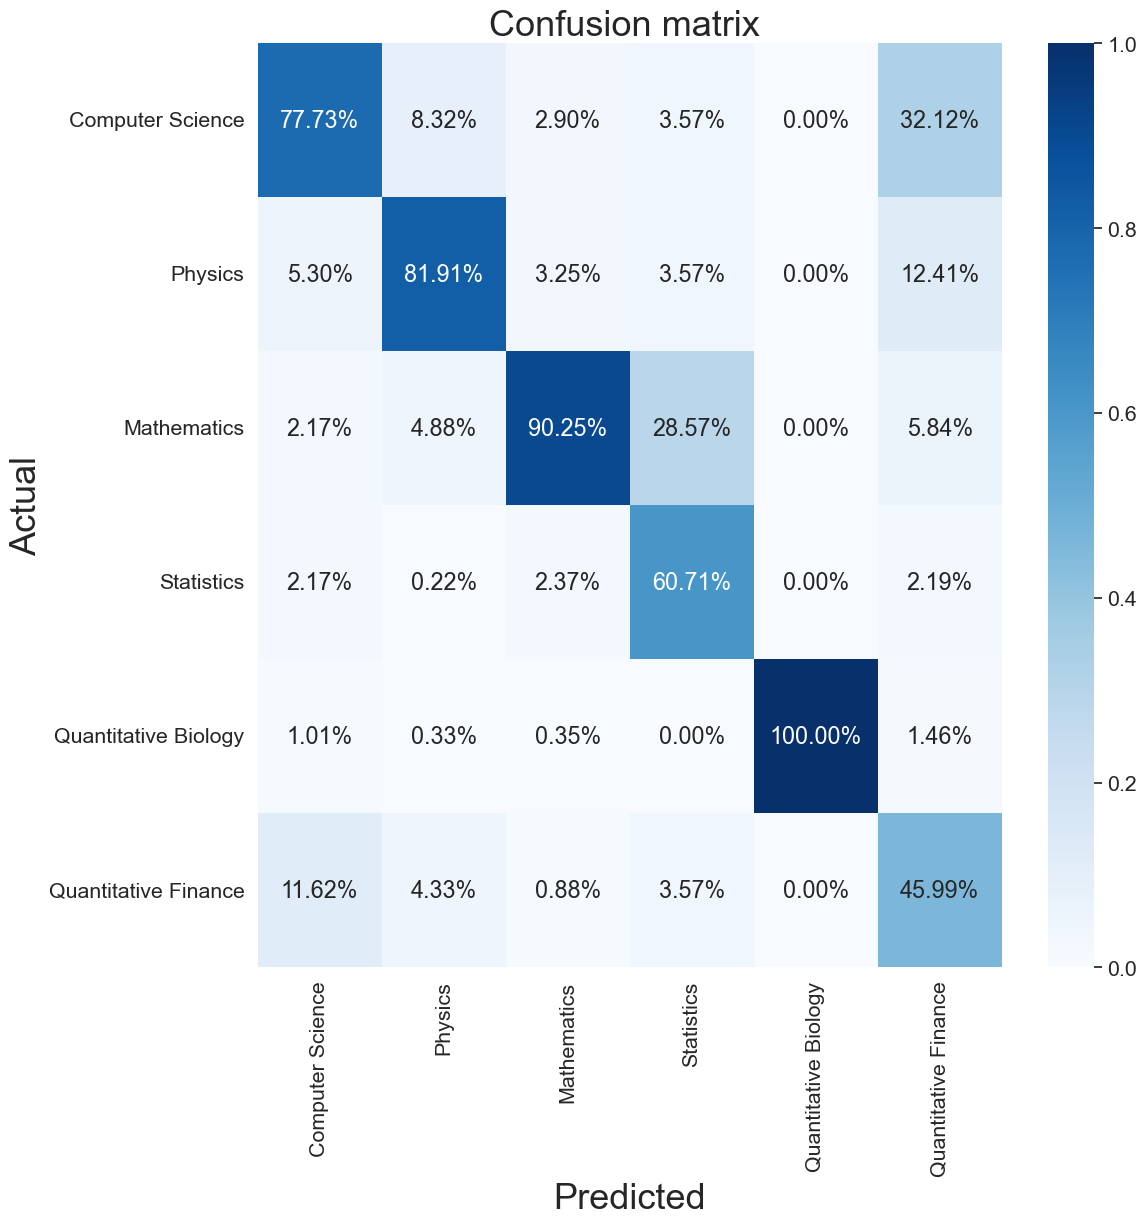

In [39]:
c_matrix = confusion_matrix(y_test_new,clf.predict(X_test_tfidf))

c_matrix = pd.DataFrame(c_matrix,columns=['Computer Science', 
                                          'Physics',
                                          'Mathematics', 
                                          'Statistics', 
                                          'Quantitative Biology', 
                                          'Quantitative Finance'],
                        index=['Computer Science',
                               'Physics',
                               'Mathematics',
                               'Statistics',
                               'Quantitative Biology',
                               'Quantitative Finance'])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix), fmt="0.2%", annot=True, cmap="Blues", ax=ax)
ax.set_title("Confusion matrix ", fontsize=26)
ax.set_xlabel("Predicted", fontsize=26)
ax.set_ylabel("Actual", fontsize=26)

We got 79.93 accuracy using logistic regression and the macro average F1 score is 0.4557.

# References

* https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/  
* https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff  
* https://www.thepythoncode.com/article/text-classification-using-tensorflow-2-and-keras-in-python   
* https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles/code

In [40]:
print(f"Execution took: {((time.time() - begin)/60)} minutes")

Execution took: 0.9313325047492981 minutes
